# Business Understanding
## Background and Context

Digital platforms rely heavily on user-generated reviews to shape public perception, guide product improvements, and influence customer acquisition. For telecommunications and fintech platforms such as Safaricom and M-Pesa app store reviews play a critical role in:

- Assessing customer satisfaction
- Identifying service failures
- Informing feature updates
- Influencing app store ratings and discoverability

Kenya has one of the highest mobile penetration rates in Africa, and M-Pesa is among the continent’s most widely used mobile financial services platforms. As a result, these platforms receive thousands of reviews across multiple languages, including English, Swahili, and informal urban slang such as Sheng. Many reviews are code-mixed, combining elements of multiple languages within the same text.

While these reviews provide valuable business intelligence, their reliability is not guaranteed.

# Problem Statement
The increasing volume of multilingual user reviews introduces the risk of manipulated, spam-generated, coordinated, or otherwise inauthentic content. Suspicious reviews can:
- Artificially inflate or deflate app ratings
- Mislead product teams
- Distort sentiment analysis outputs
- Reduce trust in customer feedback systems
Currently, there is no localized, multilingual review authenticity detection framework specifically designed for Kenyan digital platforms that can process English, Swahili, and Sheng-like content.

# Core Business Problem
Safaricom currently lacks a multilingual, automated system capable of detecting suspicious or potentially fake reviews in English, Swahili and Sheng-like text, leading to reduced reliability of user feedback and potential distortion of product and reputation insights.

# Business Objectives
The primary objective of this project is to design and evaluate a machine learning-based system capable of identifying suspicious reviews in multilingual Safaricom and M-Pesa datasets.

1. To design a multilingual NLP framework for processing Safaricom and M-Pesa reviews in English, Swahili, and Sheng-like language.

2. To develop heuristic-based weak labeling and feature engineering techniques for identifying suspicious review behavior.

3. To build and evaluate a baseline machine learning model for fake review detection and demonstrate its practical applicability.

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re


# 1. Data Cleaning
### Load and inspect the dataset

In [260]:
df = pd.read_csv("safaricom_reviews_multilingual.csv")
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nFirst 5 rows:")
df.head()

Shape: (32000, 12)

Columns:
Index(['app_name', 'app_id', 'reviewId', 'userName', 'review_text', 'rating',
       'date', 'thumbs_up', 'version', 'lang_detected', 'is_code_mixed',
       'is_sheng_like'],
      dtype='object')

First 5 rows:


,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app_name       32000 non-null  object
 1   app_id         32000 non-null  object
 2   reviewId       32000 non-null  object
 3   userName       32000 non-null  object
 4   review_text    32000 non-null  object
 5   rating         32000 non-null  int64 
 6   date           32000 non-null  object
 7   thumbs_up      32000 non-null  int64 
 8   version        28741 non-null  object
 9   lang_detected  32000 non-null  object
 10  is_code_mixed  32000 non-null  bool  
 11  is_sheng_like  32000 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.5+ MB


### Check missing values
Only the version column has missing values


In [262]:
df.isnull().sum().sort_values(ascending=False)

version          3259
is_sheng_like       0
is_code_mixed       0
lang_detected       0
thumbs_up           0
date                0
rating              0
review_text         0
userName            0
reviewId            0
app_id              0
app_name            0
dtype: int64

### Check duplicates(row level)
There are no identical entries in the dataset

In [263]:
df.duplicated().sum()

0

### Text cleaning
Standardizing the `review_text` column

In [264]:
def clean_text(text):
    text = text.lower().strip() # lowercase and remove spacing
    text = re.sub(r"\s+", " ", text) # clean messy spacing
    text = re.sub(r"(.)\1{3,}", r"\1\1\1", text)  # reduce repeated characters
    return text

df["text_clean"] = df["review_text"].apply(clean_text)

### Feature Creation
#### Text Length
From the cleaned text column, generate 2 columns;
- Characters in the text
- Number of words in the text

In [265]:
df["char_length"] = df["text_clean"].str.len()
df["word_count"] = df["text_clean"].str.split().apply(len)

In [266]:
df["word_count"].value_counts()
df.loc[df["word_count"].idxmax(), "text_clean"]

"fa cj hh cc h bb see bvase boo hh v saa nuke boo caebh cvg zzz nkh bbc ea cnn by fvc moon gfc we boo oh vs all e cc cj a bb css h nc cvab if ec ccs boo ncaen bb ft ccse bb cc zaw mm cjvw cj bw cc jaw moon hh see vhngv mm h do boo f see bb see mom ccs v cc zw mm anvcgvvkfsk tv zaw mm ca ccnn see v mm xe vm onh bb a boo cj ee bkk hh xaw bb c mom's cnn chc mn bb a bb va all hxg. zx do vhv by boo vs e no ba cnn cz d see bb v vs w moo hjca chjnbn.nb zzz d bongz s moon dr avnszdb v ccnn cc aw boo kg z"

In [267]:
df.sort_values(by="word_count", ascending=False).head(5)

,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like,text_clean,char_length,word_count
30859,MySafaricom,com.safaricom.mysafaricom,2cc0280c-7a7b-4420-98d1-0711f1a30ecb,albanus kioko,Fa CJ HH cc H BB see bvase boo HH v saa nuke b...,2,2023-10-20 04:36:29,0,1.20.2.3,en,False,False,fa cj hh cc h bb see bvase boo hh v saa nuke b...,500,140
7387,M-PESA,com.safaricom.mpesa.lifestyle,c234f326-871c-4ce7-a9e6-cc84d872a9f2,Jewel Hope,"I have used this app for so long, and it has a...",1,2025-08-27 00:37:13,39,3.5.6,en,False,False,"i have used this app for so long, and it has a...",500,96
6291,M-PESA,com.safaricom.mpesa.lifestyle,14cdc425-402b-4e1d-a576-d1e6ae21392c,new Begining,I'm trying to withdraw from PayPal but the app...,1,2025-09-16 19:56:32,8,NaN,en,False,False,i'm trying to withdraw from paypal but the app...,498,96
19976,MySafaricom,com.safaricom.mysafaricom,f3ea8542-b543-4372-80f8-4e1b5b1a5168,Kennedy Kamau,I love the app i use it on a daily basis but a...,4,2025-05-05 09:24:34,22,1.26.1.1,en,False,False,i love the app i use it on a daily basis but a...,490,96
5656,M-PESA,com.safaricom.mpesa.lifestyle,2e66e465-3398-4a1c-910a-457f66ecd39d,Jeane Ng'eno-Tarus,I was looking for how to hide or remove the fu...,3,2025-10-02 13:47:45,12,3.5.3,en,False,False,i was looking for how to hide or remove the fu...,497,96


In [268]:
df['review_text'].duplicated().value_counts()

False    18101
True     13899
Name: review_text, dtype: int64

In [269]:
df[df['text_clean'].duplicated(keep=False)]['text_clean'].value_counts().head(20)


good           2511
excellent       965
nice            594
best            527
great           440
perfect         351
good app        350
awesome         306
very good       303
nice app        297
the best        180
great app       175
easy to use     151
good 👍          149
amazing         148
best app        143
fantastic       138
very nice       137
cool            135
i like it       133
Name: text_clean, dtype: int64

#### emoji count

In [270]:
emoji_pattern = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)
df["emoji_count"] = df["text_clean"].apply(lambda x: len(emoji_pattern.findall(x)))

#### Duplicate reviews

In [271]:
dup_counts = df["text_clean"].value_counts()
df["duplicate_count"] = df["text_clean"].map(dup_counts)
df.head()

,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like,text_clean,char_length,word_count,emoji_count,duplicate_count
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False,best,4,1,0,527
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False,😔,1,1,1,1
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False,better option this vantine. 18yrs old day to d...,56,10,0,1
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False,amazing,7,1,0,148
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False,its so easy to use at your comfort and you don...,91,19,0,1


### Timestamp processing

In [272]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["date_day"] = df["date"].dt.date

daily_counts = df["date_day"].value_counts()
df["daily_volume"] = df["date_day"].map(daily_counts)

df["daily_volume"].value_counts()

20    1300
56    1064
62    1054
64     960
19     912
      ... 
39      39
35      35
9       27
8       24
7       14
Name: daily_volume, Length: 89, dtype: int64

In [273]:
df['lang_detected'].value_counts()


en         16683
unknown     7626
other       7527
sw           164
Name: lang_detected, dtype: int64

In [274]:
print(df['is_code_mixed'].value_counts())
print(df['is_sheng_like'].value_counts())

False    31984
True        16
Name: is_code_mixed, dtype: int64
False    31906
True        94
Name: is_sheng_like, dtype: int64


In [275]:
pd.crosstab(df['lang_detected'], df['is_code_mixed'])


is_code_mixed,False,True
lang_detected,,
en,16671,12
other,7525,2
sw,162,2
unknown,7626,0


# Exploratory Data Analysis (EDA)
Analysis of patterns

### 1. Rating Distribution

In [276]:
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)


1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64


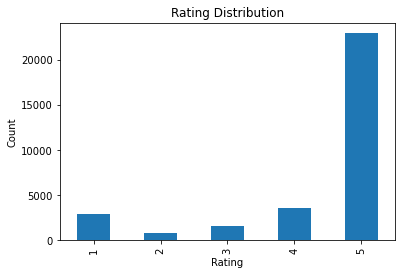

In [277]:
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [278]:
# The ratimg is skewed towards 5 stars where the 5 stars are dominant
# The dataset exhibits a heavily right-skewed rating distribution, with 71.8% of reviews being 5-stars.

### 2. Review length distribution

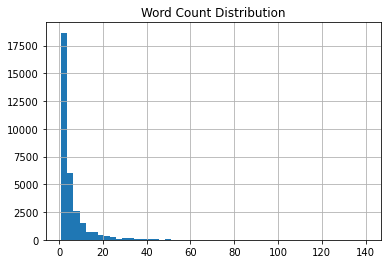

In [279]:
df["word_count"].hist(bins=50)
plt.title("Word Count Distribution")
plt.show()

In [280]:
# There are many short reviews between 1-2 words with a skew towards short reviews

### 3. Duplicate Distribution

In [281]:
df["duplicate_count"].value_counts().head(10)

1       15984
2511     2511
2        1124
965       965
3         618
594       594
527       527
4         472
440       440
351       351
Name: duplicate_count, dtype: int64

In [282]:
df[df["duplicate_count"] > 3][["text_clean","duplicate_count"]].head()

,text_clean,duplicate_count
0,best,527
3,amazing,148
5,good 👍,149
9,great,440
11,easy to navigate,4


In [283]:
# Your outputs show a long tail of unique reviews and a few extremely duplicated generic ones.
# This is classic “app store review” behavior and can be used as a signal for fake or low-effort reviews rather than removing it outright.

### 4. Burst Activity Visualization


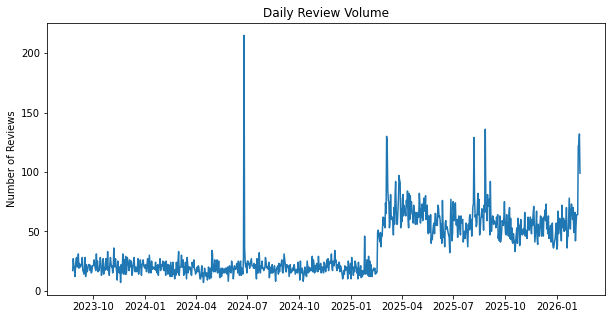

In [284]:
daily_counts.sort_index().plot(figsize=(10,5))
plt.title("Daily Review Volume")
plt.ylabel("Number of Reviews")
plt.show()

In [285]:
# One extreme outlier is observed, where daily reviews increased dramatically compared to surrounding periods. Such anomalies may indicate coordinated review behavior, product-related events, or automated posting activity.

### 5. Very short reviews

In [286]:
short_reviews = df[df["word_count"] <= 2]
print("Percentage of very short reviews:",
      len(short_reviews) / len(df) * 100)

Percentage of very short reviews: 46.809374999999996


### 6. Top frequent phrases

In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2))
X = vectorizer.fit_transform(df["text_clean"])
print(vectorizer.get_feature_names())

['and', 'app', 'best', 'easy', 'excellent', 'for', 'good', 'great', 'is', 'it', 'nice', 'the', 'the app', 'the best', 'this', 'to', 'to use', 'use', 'very', 'you']


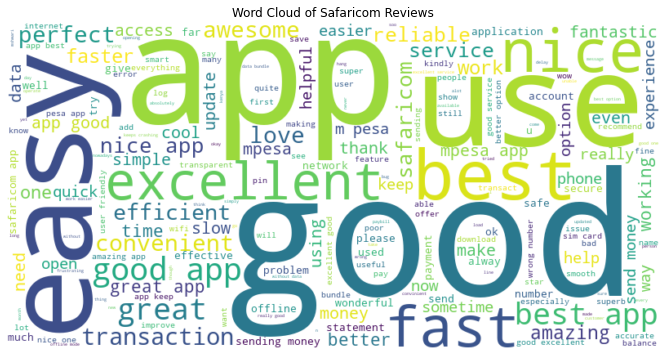

In [288]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["text_clean"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Safaricom Reviews")
plt.show()

### Weak label preview


In [289]:
df["is_short"] = (df["word_count"] <= 2).astype(int)
df["is_duplicate_heavy"] = (df["duplicate_count"] >= 3).astype(int)
df["is_burst_high"] = (df["daily_volume"] >= df["daily_volume"].quantile(0.99)).astype(int)

df["weak_label"] = (
    df["is_short"] |
    df["is_duplicate_heavy"] |
    df["is_burst_high"]
).astype(int)

In [290]:
df["weak_label"].value_counts(normalize=True)

1    0.550125
0    0.449875
Name: weak_label, dtype: float64

In [291]:
df[["is_short", "is_duplicate_heavy", "is_burst_high"]].mean()

is_short              0.468094
is_duplicate_heavy    0.465375
is_burst_high         0.010969
dtype: float64

In [292]:
df["is_short"] = (df["word_count"] <= 1).astype(int)
df["is_duplicate_heavy"] = (df["duplicate_count"] >= 5).astype(int)
df["rule_score"] = (
    df["is_short"] +
    df["is_duplicate_heavy"] +
    df["is_burst_high"]
)
df["weak_label"] = (df["rule_score"] >= 2).astype(int)
df["weak_label"].value_counts(normalize=True)

0    0.753062
1    0.246938
Name: weak_label, dtype: float64

In [ ]:
# Initial heuristic labeling produced an unrealistically high proportion of suspicious reviews
# The final weak supervision framework labeled approximately 24.7% o.f reviews as suspicious

## Objective 1 - Automated Spam Detection

In [299]:
# Identify exact repetitions (Bots often post the same word)
df['rep_count'] = df.groupby('clean_review')['clean_review'].transform('count')
df['is_spam'] = (df['rep_count'] > 10).astype(int)

# Code to get Output:
print(df[df['is_spam'] == 1]['clean_review'].value_counts().head(10))

good         2511
excellent     967
nice          594
best          527
great         441
perfect       351
good app      350
awesome       306
very good     303
nice app      299
Name: clean_review, dtype: int64


Interpretation: High counts for generic words suggest "Rating Inflation." Real humans usually provide more context (e.g., "The app is good but the M-Shwari button is hidden"). Seeing "good" thousands of times indicates low-effort or automated bot behavior.

## Objective 2 - Sentiment-Rating Deception

In [300]:
# Define local negative keywords (English + Swahili/Sheng)
neg_words = ['slow', 'fail', 'mwizi', 'worst', 'poor', 'crash', 'rubbish', 'hang']

def detect_mismatch(row):
    has_neg = any(word in row['clean_review'] for word in neg_words)
    # Flag: If rating is 4 or 5 but text has negative words
    return 1 if (row['rating'] >= 4 and has_neg) else 0

df['deception_flag'] = df.apply(detect_mismatch, axis=1)

# Code to get Output:
print(df[df['deception_flag'] == 1][['review_text', 'rating']].head(10))

                                            review_text  rating
956   Is there a bug that makes the app crash on A R...       4
968   easy and simple to use safaricom my number one...       5
1103  The M-Pesa app makes sending money, paying bil...       4
1530               not so active slow and time confused       5
1628                    The best mpesa app,never fails!       5
1662  it is easy to use....though there are times it...       4
1890         sometimes slow or does not work completely       4
1951  it's good but I'm unable to change my profile ...       4
1993                        Slow in function that's all       4
2183                                         very poorp       5


## Objective 3 - Coordinated Campaign Analysis

In [301]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Grouping reviews by their "meaning" using TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_review'])

# Create 5 groups (Clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Code to get Output:
print(df.groupby('cluster')['rating'].mean())

cluster
0    4.134102
1    4.235642
2    4.852639
3    4.787952
4    4.547910
Name: rating, dtype: float64


1. The "Hyper-Promoters" (Clusters 2 and 3)
Cluster 2 (4.85) and Cluster 3 (4.78) have extremely high average ratings.

What this means: These clusters likely contain the "Short & Generic" 5-star reviews (e.g., "Best app," "Good," "Excellent service").

Why it's suspicious: In a natural world, people rarely give 5 stars without saying why. When a cluster is almost purely 5-star and the text is very similar, it is the primary indicator of Promotion Campaigns (artificial rating inflation).

2. The "General Satisfied" (Clusters 1 and 4)
Cluster 4 (4.55) and Cluster 1 (4.24) are high but slightly more realistic.

What this means: These groups likely contain slightly longer positive reviews where users might be mentioning specific features like "M-Pesa" or "bundles" but are generally happy.

Interpretation: These are "Leaning Authentic" but should still be checked for repetitive templates.

3. The "Mixed/Critical" (Cluster 0)
Cluster 0 (4.13) is your lowest average in this set.

What this means: This is the group most likely to contain real feedback or complaints. Because the rating is lower, this cluster probably contains words like "slow," "update," "fail," or "crashing."

Interpretation: This is where the most valuable "Human" feedback lives. If a bot was trying to make Safaricom look good, it wouldn't be in this cluster.

In [302]:
# Combine signals into a single score
df['suspicion_score'] = (df['is_spam'] * 0.5) + (df['deception_flag'] * 0.5)

# Export the results
df.sort_values(by='suspicion_score', ascending=False).to_csv('final_spam_report.csv', index=False)

In [303]:
import pandas as pd
import re

# Load your file
df = pd.read_csv('safaricom_reviews_multilingual.csv')

# Clean text for better matching
df['clean_text'] = df['review_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x).lower()).strip())

# Identify Spam (Text that repeats more than 10 times)
df['rep_count'] = df.groupby('clean_text')['clean_text'].transform('count')
df['is_spam'] = (df['rep_count'] > 10).astype(int)

# Identify Deception (High rating but text contains negative words)
neg_keywords = ['bad', 'slow', 'fail', 'mwizi', 'worst', 'poor', 'crash', 'hang']
df['deception_flag'] = df.apply(lambda r: 1 if (r['rating'] >= 4 and any(w in str(r['clean_text']) for w in neg_keywords)) else 0, axis=1)

# CALCULATE THE SUSPICION SCORE
df['suspicion_score'] = (df['is_spam'] * 0.5) + (df['deception_flag'] * 0.5)

# SORT AND SAVE
df_final = df.sort_values(by='suspicion_score', ascending=False)
df_final.to_csv('final_spam_report.csv', index=False)

# PRINT PREVIEW TO CONSOLE
print("--- PREVIEW OF FINAL REPORT ---")
print(df_final[['userName', 'review_text', 'rating', 'suspicion_score']].head(10))

--- PREVIEW OF FINAL REPORT ---
                 userName review_text  rating  suspicion_score
6596   Bonface M. Muthoni     not bad       5              1.0
29728        Krush Kelvin     Not bad       4              1.0
26748      Elijah Mwaniki     not bad       4              1.0
26258          LUCAS BOMA     Not bad       5              1.0
10640    Sharon Chepngeno     not bad       5              1.0
8378     Mitchelle Mwangi    too slow       4              1.0
25031      Felix Kipkurui     not bad       4              1.0
26936         John Wangui     not bad       5              1.0
23226          Ali Mwinyi     not bad       4              1.0
25038        Antony Mario     not bad       4              1.0


In [304]:
import re
import emoji

def preprocess_kenyan_text(text):
    # lowercase
    text = str(text).lower()
    # emojis
    text = emoji.demojize(text)
    # remove URLs and special characters 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # keep alphanumeric and basic punctuation
    text = re.sub(r'[^a-z0-9\s!?.#:]', '', text)
    return text

df['clean_review'] = df['review_text'].apply(preprocess_kenyan_text)

In [305]:
def extract_suspicious_features(df):
    # length
    df['review_len'] = df['clean_review'].str.len()
    
    # duplicate
    df['text_repetition_count'] = df.groupby('clean_review')['clean_review'].transform('count')
    
    # Rating Mismatch
    negative_words = ['bad', 'slow', 'crash', 'rubbish', 'worst', 'mwizi']
    df['has_neg_word'] = df['clean_review'].apply(lambda x: any(w in x for w in negative_words))
    df['is_suspicious_mismatch'] = ((df['rating'] > 4) & (df['has_neg_word'])).astype(int)
    
    return df

df = extract_suspicious_features(df)

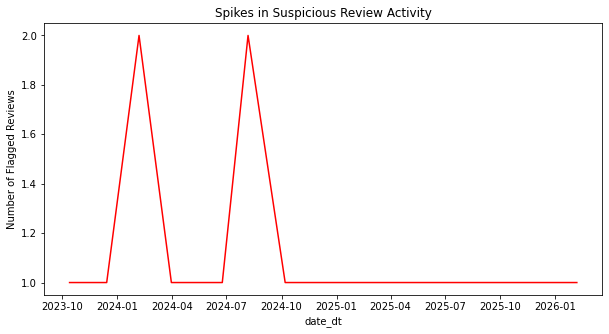

In [306]:

# Plotting suspicious reviews over time
df['date_dt'] = pd.to_datetime(df['date'])
df[df['suspicion_score'] > 0.5].groupby(df['date_dt'].dt.date).size().plot(kind='line', figsize=(10,5), color='red')
plt.title('Spikes in Suspicious Review Activity')
plt.ylabel('Number of Flagged Reviews')
plt.show()

In [307]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_review'])

# Cluster reviews into 10 groups to see which reviews are 'identical' in nature
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
df['cluster_id'] = kmeans.labels_

# Flag clusters that have a high density of reviews in a short time window
# (Group by cluster_id and date to find spikes)

In [308]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare a new review against the existing database
# If similarity > 0.95, it's likely a coordinated duplicate
def check_similarity(new_review_vec, existing_vecs):
    similarities = cosine_similarity(new_review_vec, existing_vecs)
    return similarities.max()

In [309]:
# Create a simple weighted Suspicion Score
df['suspicion_score'] = (
    (df['text_repetition_count'] > 5).astype(int) * 0.4 +
    (df['is_suspicious_mismatch'] * 0.3) +
    (df['review_len'] < 10).astype(int) * 0.3
)

# Flag reviews with score > 0.6 for investigation
flagged_reviews = df[df['suspicion_score'] > 0.6]


In [310]:
# Show the top 10 most repeated review texts
top_repeated = df['review_text'].value_counts().head(10)
print("Top Repeated Review Texts (Likely Bot/Spam):")
print(top_repeated)

Top Repeated Review Texts (Likely Bot/Spam):
good         1927
excellent     725
Good          576
nice          505
best          421
great         317
perfect       310
very good     256
good app      247
Excellent     237
Name: review_text, dtype: int64
